### Random Forests at 20-days leadtime for all regions.

File generated 9/25/2025

This file utilizes definition statements containing RF architecture to create three separate RF models, each for a designated forecast region. 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

import keras
import shap

##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

2025-09-25 21:01:32.955827: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 21:01:32.986124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-25 21:01:32.986145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-25 21:01:32.986952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-25 21:01:32.991679: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#import definitions 
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS
from SkillStats_MOD import PAS

#first RF arch
from RF_arch1 import rf_featselect
#second RF arch
from RF_arch2 import rf_90thpercentile

In [3]:
#load input data, it is max/min standardized, NaNs removed
#stratospheric polar vortex ellipse diagnostics from Fernandez et al 2025 (in review)

infile = open("../../data/nolag_extendedanom_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

nolag_input.shape 

(62, 149, 8)

The input data stays the same regardless of forecast region. 

The original array starts on October 19th. The shift send this forward to November 2nd. 

In [4]:
##CHANGE THIS CALL BASED ON LEAD TIME.
idx = 129 #129 for 20, 119 for 30.
inp1 = np.empty((62,idx,8)) #create new input array, 14 day lag. 
shift = 20

In [5]:
##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:62,shift:,0] ##wind
inp1[:,:,1] = nolag_input[:62,shift:,1] ##ratio
inp1[:,:,2] = nolag_input[:62,shift:,2] ##latitude
inp1[:,:,3] = nolag_input[:62,shift:,3] ##longitude
inp1[:,:,4] = nolag_input[:62,shift:,4] ##size
inp1[:,:,5] = nolag_input[:62,shift:,5] ##ephi
inp1[:,:,6] = nolag_input[:62,shift:,7] ##pv
inp1[:,:,7] = nolag_input[:62,shift:,6] ##gph

inp=inp1.reshape(62*idx,8)

In [6]:
#convert to pandas dataframe
input = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','pv','gph']
#col_names = ['wind','rat','cenlat','cenlon','size','ephi','pv']
input.columns = col_names

#input

Load in temperature files. 

In [7]:
#load output data file.
infile = open("../../data/eur_anomtemps_reduced.p","rb",)
temp = pickle.load(infile) 
europe_temp = temp.reshape(62,149)
infile.close()

infile = open("../../data/nova_anomtemps_reduced.p","rb",)
temp = pickle.load(infile) 
canada_temp = temp.reshape(62,149)
infile.close()

infile = open("../../data/seus_anomtemps_reduced.p","rb",)
temp = pickle.load(infile) 
seus_temp = temp.reshape(62,149)
infile.close()

# load climo data
infile = open("../../data/eur_climoprob_reduced.p","rb",)
climo = pickle.load(infile) 
europe_climo = climo.reshape(62,149,2)
infile.close()

infile = open("../../data/nova_climoprob_reduced.p","rb",)
climo = pickle.load(infile) 
canada_climo = climo.reshape(62,149,2)
infile.close()

infile = open("../../data/seus_climoprob_reduced.p","rb",)
climo = pickle.load(infile) 
seus_climo = climo.reshape(62,149,2) 
infile.close()

In [8]:
##reshape temp files again to introduce lag. 
eur_output = europe_temp[:,shift:].reshape(62*idx)
can_output = canada_temp[:,shift:].reshape(62*idx)
seu_output = seus_temp[:,shift:].reshape(62*idx)
print("Check temp shape:", eur_output.shape)

##reshaping climo
eur_climo = europe_climo[:,shift:,:].reshape(62*idx,2)
can_climo = canada_climo[:,shift:,:].reshape(62*idx,2)
seu_climo = seus_climo[:,shift:,:].reshape(62*idx,2)
print("Check climo shape:", eur_climo.shape)

Check temp shape: (7998,)
Check climo shape: (7998, 2)


### Begin RF Feature selection test. 

In [9]:
#number of cross validations
n = 100

Begin CV ...
###################################################
Accuracy, Validation: 56.32%
Accuracy, Training: 63.09%
Accuracy, Testing: 60.17%


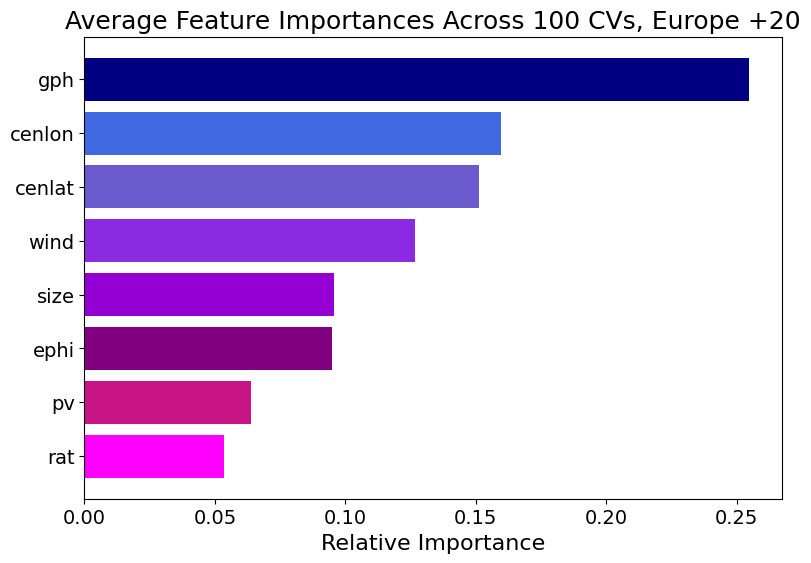

In [10]:
##Europe Feature Selection
eur_important = rf_featselect(n,idx,input,eur_output,eur_climo)

imp = np.nanmean(eur_important, axis = 0)
imp.shape

#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across 100 CVs, Europe +20",fontsize =18)
plt.barh(range(input.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(input.shape[1]), input.columns[indices],fontsize =14)
plt.xticks(fontsize =14)
plt.xlabel("Relative Importance",fontsize =16)
plt.gca().invert_yaxis()
plt.savefig("./images/EurRF_FeatureImportance_20days.png",bbox_inches = 'tight')

Begin CV ...
###################################################
Accuracy, Validation: 68.82%
Accuracy, Training: 71.35%
Accuracy, Testing: 71.90%


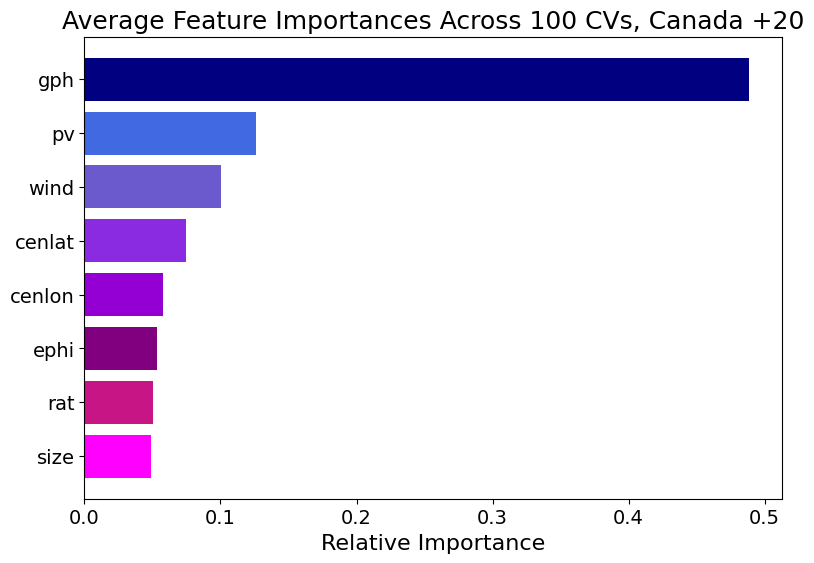

In [11]:
##Canada Feature Selection
can_important = rf_featselect(n,idx,input,can_output,can_climo)

imp = np.nanmean(can_important, axis = 0)
imp.shape

#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across 100 CVs, Canada +20",fontsize =18)
plt.barh(range(input.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(input.shape[1]), input.columns[indices],fontsize =14)
plt.xticks(fontsize =14)
plt.xlabel("Relative Importance",fontsize =16)
plt.gca().invert_yaxis()
plt.savefig("./images/CanRF_FeatureImportance_20days.png",bbox_inches = 'tight')

Begin CV ...
###################################################
Accuracy, Validation: 60.92%
Accuracy, Training: 63.17%
Accuracy, Testing: 59.16%


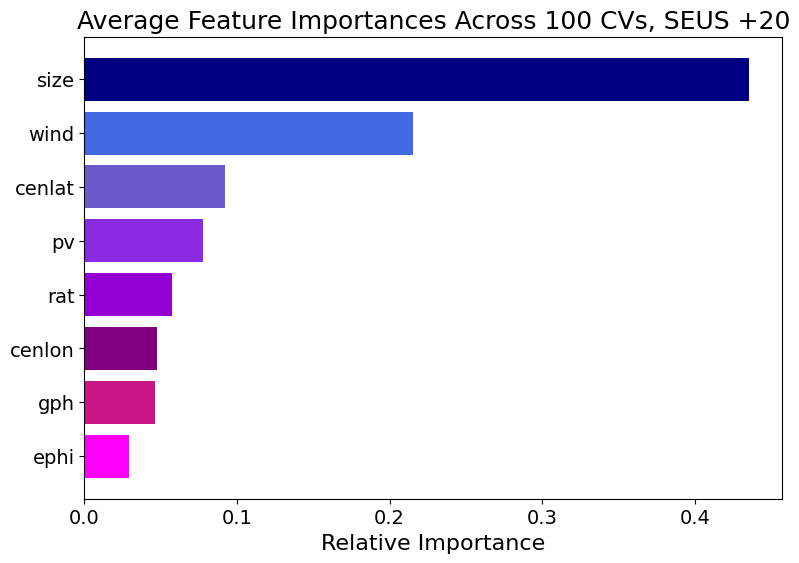

In [12]:
##SEUS Feature Selection
seu_important = rf_featselect(n,idx,input,seu_output,seu_climo)

imp = np.nanmean(seu_important, axis = 0)
imp.shape

#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across 100 CVs, SEUS +20",fontsize =18)
plt.barh(range(input.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(input.shape[1]), input.columns[indices],fontsize =14)
plt.xticks(fontsize =14)
plt.xlabel("Relative Importance",fontsize =16)
plt.gca().invert_yaxis()
plt.savefig("./images/SeuRF_FeatureImportance_20days.png",bbox_inches = 'tight')

## Second RF run post feature selection

In [13]:
##change pandas dataframe to choose top 3 important features only
eur_input = input[["wind","cenlon","cenlat","gph"]]
can_input = input[["wind","pv","cenlat","gph"]]
seu_input = input[["wind","pv","size","cenlat"]]

### Europe

In [14]:
##Europe Forecasts of opportunity
eur_test90, eur_fulltest, eur_shap_obj, eur_posXtest, eur_FposXtest, eur_negXtest, eur_FnegXtest = rf_90thpercentile(n,idx,eur_input,eur_output,eur_climo)

Load in data ...
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 56.93%
Accuracy, Training: 61.85%
Accuracy, Testing: 60.89%
_____________________________________________________________________
Brier Skill Score (Train): 0.0653
Brier Skill Score (Test): 0.0644
Brier Skill Score (Validation): 0.0126
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.7710
Recall Accuracy Score (Test): 0.8011
Recall AccuracyScore (Validation): 0.7396
Precision Accuracy Score (Train): 0.6132
Precision Accuracy Score (Test): 0.5917
Precision AccuracyScore (Validation): 0.5735
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.4441
Recall Accuracy Score (Test): 0.4005
Recall AccuracyScore (Validation): 0.3799
Precision

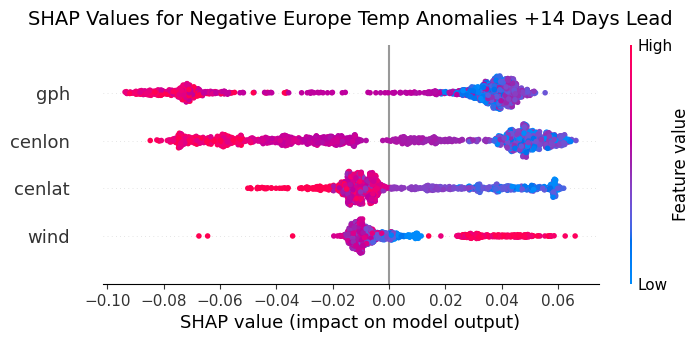

In [15]:
plt.title("SHAP Values for Negative Europe Temp Anomalies +14 Days Lead",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(eur_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
#plt.savefig("./images/EllipseRFSHAP_Eur_14days.png",bbox_inches = 'tight')

Text(0.5, 1.0, 'Testing Prediction ACC Across 100 RF Models, Europe +14')

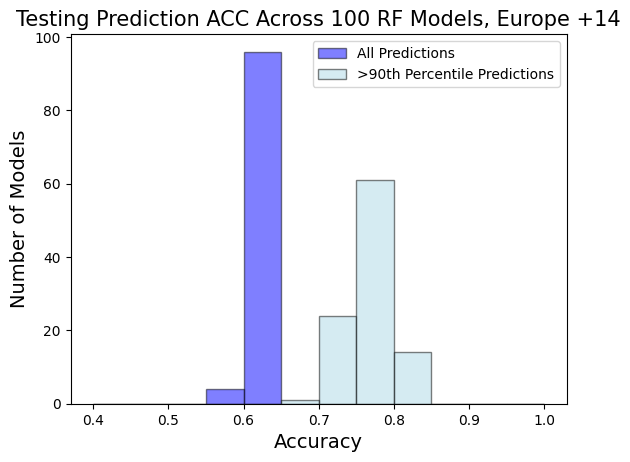

In [16]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(eur_test90, bins=bins)
countsfull, edgesfull = np.histogram(eur_fulltest, bins=bins)
#plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')

#plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =14)
plt.ylabel('Number of Models',fontsize =14)
plt.legend()
plt.title('Testing Prediction ACC Across 100 RF Models, Europe +14',fontsize =15)
#plt.savefig("./images/GPHndEllipse_ACC.png",bbox_inches = 'tight')

### Canada

In [17]:
##Canada Forecasts of opportunity
can_test90, can_fulltest, can_shap_obj, can_posXtest, can_FposXtest, can_negXtest, can_FnegXtest = rf_90thpercentile(n,idx,can_input,can_output,can_climo)

Load in data ...
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 69.11%
Accuracy, Training: 70.97%
Accuracy, Testing: 71.64%
_____________________________________________________________________
Brier Skill Score (Train): 0.1796
Brier Skill Score (Test): 0.1594
Brier Skill Score (Validation): 0.1380
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.8721
Recall Accuracy Score (Test): 0.8944
Recall AccuracyScore (Validation): 0.8580
Precision Accuracy Score (Train): 0.7083
Precision Accuracy Score (Test): 0.7129
Precision AccuracyScore (Validation): 0.6974
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.4705
Recall Accuracy Score (Test): 0.4398
Recall AccuracyScore (Validation): 0.4420
Precision

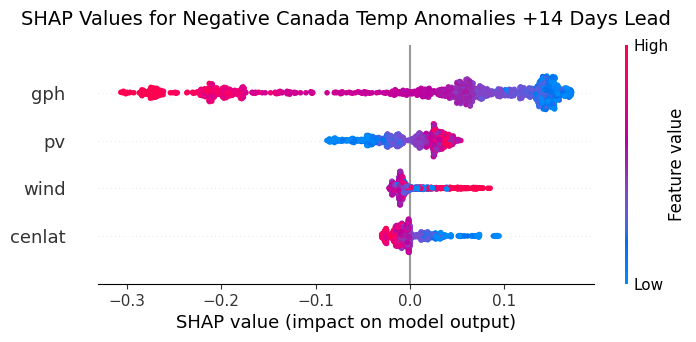

In [18]:
plt.title("SHAP Values for Negative Canada Temp Anomalies +14 Days Lead",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(can_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
#plt.savefig("./images/EllipseRFSHAP_Eur_14days.png",bbox_inches = 'tight')

Text(0.5, 1.0, 'Testing Prediction ACC Across 100 RF Models, Canada +14')

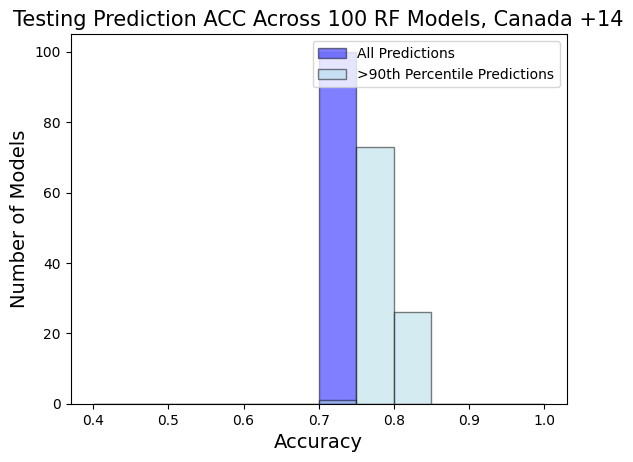

In [19]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(can_test90, bins=bins)
countsfull, edgesfull = np.histogram(can_fulltest, bins=bins)
#plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')

#plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =14)
plt.ylabel('Number of Models',fontsize =14)
plt.legend()
plt.title('Testing Prediction ACC Across 100 RF Models, Canada +14',fontsize =15)
#plt.savefig("./images/GPHndEllipse_ACC.png",bbox_inches = 'tight')

### S.E. U.S.

In [20]:
##SEUS Forecasts of opportunity
seu_test90, seu_fulltest, seu_shap_obj, seu_posXtest, seu_FposXtest, seu_negXtest, seu_FnegXtest = rf_90thpercentile(n,idx,seu_input,seu_output,seu_climo)

Load in data ...
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 61.46%
Accuracy, Training: 62.92%
Accuracy, Testing: 60.38%
_____________________________________________________________________
Brier Skill Score (Train): 0.0901
Brier Skill Score (Test): 0.0445
Brier Skill Score (Validation): 0.0603
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.7332
Recall Accuracy Score (Test): 0.7168
Recall AccuracyScore (Validation): 0.7279
Precision Accuracy Score (Train): 0.6275
Precision Accuracy Score (Test): 0.6007
Precision AccuracyScore (Validation): 0.6148
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.5128
Recall Accuracy Score (Test): 0.4811
Recall AccuracyScore (Validation): 0.4869
Precision

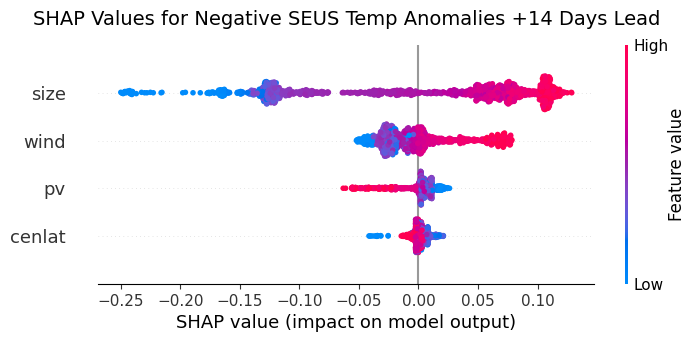

In [21]:
plt.title("SHAP Values for Negative SEUS Temp Anomalies +14 Days Lead",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(seu_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
#plt.savefig("./images/EllipseRFSHAP_Eur_14days.png",bbox_inches = 'tight')

Text(0.5, 1.0, 'Testing Prediction ACC Across 100 RF Models, SEUS +14')

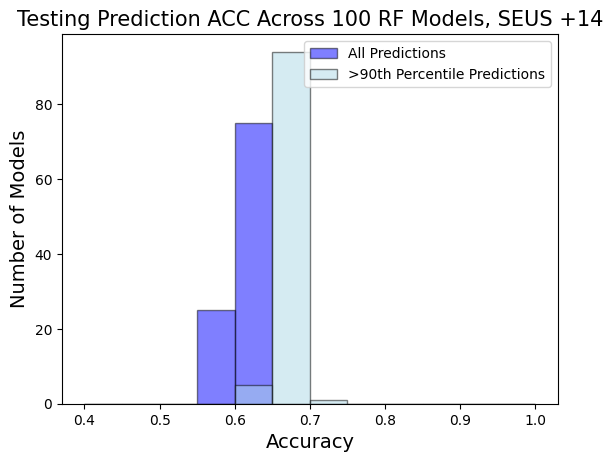

In [22]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(seu_test90, bins=bins)
countsfull, edgesfull = np.histogram(seu_fulltest, bins=bins)
#plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')

#plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =14)
plt.ylabel('Number of Models',fontsize =14)
plt.legend()
plt.title('Testing Prediction ACC Across 100 RF Models, SEUS +14',fontsize =15)
#plt.savefig("./images/GPHndEllipse_ACC.png",bbox_inches = 'tight')

### Pickle out index files. 

In [23]:
##export out files to make the next few plots w/o normalization
pickle.dump(eur_posXtest, open("./index/posXtest_eur14.p", 'wb'))
pickle.dump(eur_FposXtest, open("./index/FposXtest_eur14.p", 'wb'))
pickle.dump(eur_negXtest, open("./index/negXtest_eur14.p", 'wb'))
pickle.dump(eur_FnegXtest, open("./index/FnegXtest_eur14.p", 'wb'))

pickle.dump(can_posXtest, open("./index/posXtest_can14.p", 'wb'))
pickle.dump(can_FposXtest, open("./index/FposXtest_can14.p", 'wb'))
pickle.dump(can_negXtest, open("./index/negXtest_can14.p", 'wb'))
pickle.dump(can_FnegXtest, open("./index/FnegXtest_can14.p", 'wb'))

pickle.dump(seu_posXtest, open("./index/posXtest_seu14.p", 'wb'))
pickle.dump(seu_FposXtest, open("./index/FposXtest_seu14.p", 'wb'))
pickle.dump(seu_negXtest, open("./index/negXtest_seu14.p", 'wb'))
pickle.dump(seu_FnegXtest, open("./index/FnegXtest_seu14.p", 'wb'))